In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from sklearn.metrics import mean_squared_error
from google.colab import drive


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
#drive.mount('/content/gdrive')
#!unzip gdrive/My\ Drive/CECS457/lfw.zip

In [ ]:
path = 'lfw'

In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

torch.Size([250, 250, 3])


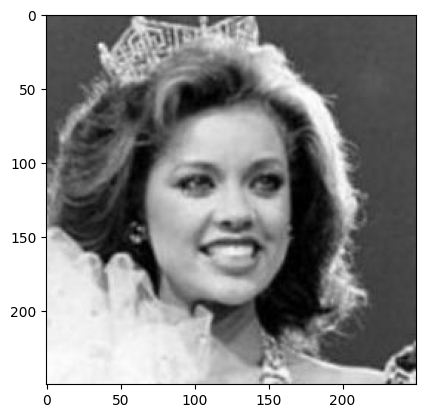

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

The dimension of an image is [250, 250, 3]. The first 2 dimension are the size of the image in pixel and the 3rd dimension is the number of color channels. So we know that the image is 250x250 pixels in size with 3 color channels which are RGB.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [ ]:
class AE(nn.Module):

    def __init__(self):
      super(AE,self).__init__()

      self.conv1 = nn.Conv2d(in_channels=250, out_channels=150, kernel_size=2, stride=1)
      self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1)

      self.conv2 = nn.Conv2d(in_channels=150, out_channels=100, kernel_size=2, stride=1, padding=1)
      self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv3 = nn.Conv2d(in_channels=100, out_channels=50, kernel_size=2, stride=1, padding=1)
      self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv4 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=2, stride=1, padding=1)
      self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv5 = nn.Conv2d(in_channels=25, out_channels=10, kernel_size=2, stride=1, padding=1)
      self.conv6 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=2, stride=1)


    def encoder(self,x):
      h = self.pool1(torch.relu(self.conv1(x)))
      h = self.pool2(torch.relu(self.conv2(h)))
      return h


    def decoder(self,x):
      h = nn.functional.interpolate(x, scale_factor = 2)
      h = torch.relu(self.conv3(h))
      h = nn.functional.interpolate(h, scale_factor = 3)
      h = torch.relu(self.conv4(h))
      h = nn.functional.interpolate(h, scale_factor = 4)
      h = torch.relu(self.conv5(h))
      h = nn.functional.interpolate(h, scale_factor = 5)
      h = torch.relu(self.conv6(h))
      return h

    def forward(self,x):
      h = self.encoder(x)
      xtilde = self.decoder(h)
      return xtilde

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [ ]:
model = AE()

In [ ]:
model(x).shape

torch.Size([3, 127, 204])

In [ ]:
for x in model.encoder:
    print(x.shape)
    plt.imshow(x)
    break

In [ ]:
for x in model.decoder:
    print(x.shape)
    plt.imshow(x)
    break

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [ ]:
for p in model.parameters():
  print(p.shape)

torch.Size([150, 250, 2, 2])
torch.Size([150])
torch.Size([100, 150, 2, 2])
torch.Size([100])
torch.Size([50, 100, 2, 2])
torch.Size([50])
torch.Size([25, 50, 2, 2])
torch.Size([25])
torch.Size([10, 25, 2, 2])
torch.Size([10])
torch.Size([3, 10, 2, 2])
torch.Size([3])


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
num_epochs = 10
# trainig loop
for epoch in range(num_epochs):
    for batch_inputs, batch_outputs in dataloader:
      optim.zero_grad()
      batch_inputs = batch_inputs.permute(0, 2, 3, 1)
      train_predicts = model(batch_inputs)
      print("in: " + str(batch_inputs.shape))
      print(train_predicts.shape)
      loss = loss_function(train_predicts, batch_inputs)
      loss.backward()
      optim.step()
    print(loss)


NameError: ignored

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [ ]:
for x,y in dataloader:
    img = x[np.random.randint(0,31)]
    plt.imshow(img)
    plt.imshow(model(img))
    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?